# 1. Preparations

In [ ]:
!pip install torchdata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 1-1. Import Libraries




In [ ]:
import os
import random
import time
import sys
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchtext import data, datasets
import time
import spacy
import numpy as np
from torch import Tensor
from torchtext.datasets import IMDB

In [ ]:
import torchtext
torchtext.__version__

'0.12.0'

### 1-2. Load data
- IMDB 데이터를 다운받습니다.
- Train,valid,test 데이터셋으로 split 합니다.

In [ ]:
#!pip install datasets

In [ ]:
# from datasets import load_dataset
# imdb=load_dataset("imdb")

In [ ]:
from torchtext.datasets import IMDB
train_iter, test_iter = IMDB(split=('train', 'test'))




*   split train data into 7:3 portion as train:valid



In [ ]:
length = len(list(train_iter))
valid_iter = list(train_iter)[int(0.7*length):]
train_iter = list(train_iter)[:int(0.7*length)]

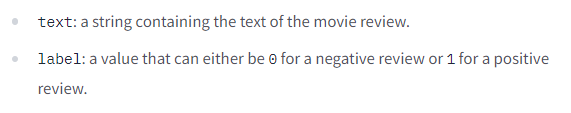

### 1-3. Building Vocabulary


*   Build the vocabulary directly with the Vocab class



In [ ]:
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('basic_english')

In [ ]:
from collections import Counter
from torchtext.vocab import vocab
from torchtext.datasets import IMDB
#train_iter = IMDB(split='train')
counter = Counter()
#for (label, line) in imdb['train']:
for (label, line) in train_iter:
    counter.update(tokenizer(line))
vocab = vocab(counter, min_freq=1, specials=('<unk>', '<BOS>', '<EOS>', '<PAD>'))
vocab.set_default_index(vocab['<unk>'])


In [ ]:
print("The length of the new vocab is", len(vocab))
new_stoi = vocab.get_stoi()
print("The index of '<BOS>' is", new_stoi['<BOS>'])
new_itos = vocab.get_itos()
print("The token at index 2 is", new_itos[2])
print("The token at index 3 is", new_itos[3])
print("The token at index 100 is", new_itos[100])

The length of the new vocab is 100686
The index of '<BOS>' is 1
The token at index 2 is <EOS>
The token at index 3 is <PAD>
The token at index 100 is ordinary






*   Build Vocabulary using GloVe 





In [ ]:
from torchtext.vocab import GloVe, vocab
unk_index = 0
bos_index = 1
eos_index = 2
pad_index = 3

glove_vectors = GloVe(name='6B', dim=100)
glove_vocab = vocab(glove_vectors.stoi)
glove_vocab.insert_token("<unk>",unk_index)
glove_vocab.insert_token("<BOS>",bos_index)
glove_vocab.insert_token("<EOS>",eos_index)
glove_vocab.insert_token("<PAD>",pad_index)
glove_vocab.set_default_index(unk_index)

vocab = glove_vocab.get_stoi()

In [ ]:
print("The length of the new vocab is", len(vocab))
new_stoi = glove_vocab.get_stoi()
print("The index of '<BOS>' is", new_stoi['<BOS>'])
new_itos = glove_vocab.get_itos()
print("The token at index 2 is", new_itos[2])
print("The token at index 2100 is", new_itos[2100])

The length of the new vocab is 400003
The index of '<BOS>' is 1
The token at index 2 is <EOS>
The token at index 2100 is stood


In [ ]:
text_transform = lambda x: [glove_vocab['<BOS>']] + [glove_vocab[token] for token in tokenizer(x)] + [glove_vocab['<EOS>']]
label_transform = lambda x: 1 if x == 'pos' else 0

# Print out the output of text_transform
print("input to the text_transform:", "here is an example")
print("output of the text_transform:", text_transform("here is an example"))

input to the text_transform: here is an example
output of the text_transform: [1, 190, 17, 32, 883, 2]


In [ ]:
# Split train and valid data
#train_data, valid_data = train_data.split(random_state = random.seed(SEED))

### 1-3. Cuda Setup
- GPU 사용을 위한 Cuda 설정
- Colab 페이지 상단 메뉴>수정>노트설정에서 GPU 사용 설정이 선행되어야 합니다.


In [ ]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda:0" if USE_CUDA else "cpu")

In [ ]:
USE_CUDA

True

In [ ]:
!nvidia-smi

Thu Jun 16 13:03:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##2. Data Loader 선언


1.   batch기반의 딥러닝 학습을 위해 mini batch 형성
2.   dataset, batch size, shuffle, collate_fn



In [ ]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
   label_list, text_list = [], []
   for (_label, _text) in batch:
        label_list.append(label_transform(_label))
        processed_text = torch.tensor(text_transform(_text))
        text_list.append(processed_text)
   return torch.tensor(label_list).to(device), pad_sequence(text_list, padding_value=3.0).to(device)

train_iter = IMDB(split='train')

In [ ]:
#batch shape확인하기

train_dataloader2 = DataLoader(list(train_iter), batch_size=32, shuffle=True, collate_fn=collate_batch)
print(next(iter(train_dataloader2)))
print(next(iter(train_dataloader2))[0])
print(next(iter(train_dataloader2))[0].size())
print(next(iter(train_dataloader2))[1].size())

(tensor([1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 1], device='cuda:0'), tensor([[   1,    1,    1,  ...,    1,    1,    1],
        [  22,   86, 2636,  ...,  507,   66,  146],
        [  10,   84,  112,  ..., 1836,   17,    4],
        ...,
        [   3,    3,    3,  ...,  322,    3,    3],
        [   3,    3,    3,  ...,    5,    3,    3],
        [   3,    3,    3,  ...,    2,    3,    3]], device='cuda:0'))
tensor([0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
torch.Size([32])
torch.Size([893, 32])


##3. Build Model
- Embedding layer, RNN layer, Dropout layer, Fully-connected layer 로 이루어진 모델을 만듭니다.
- 미리 학습된 워드 임베딩을 임베딩 레이어에 올립니다.

In [ ]:
class CustomModel(nn.Module):  # Custom model 정의 
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, dropout, pad_idx):
        super().__init__()

        # Define parameters
        self.hidden_him = hidden_dim
        self.n_layers = n_layers

        # Define Layers
        # Embedding layer
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=pad_idx)

        ### To-do ###
        # Vanilla RNN layer
        self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers, dropout=dropout)
        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        ##################

        
    def forward(self, text):

        # text = [sent len, batch size]
        
        embedded = self.embedding(text)
        
        # embedded = [sent len, batch size, emb dim]
        # embedded = [batch size, sent len, emb dim] if batch_first = True

        # Apply RNN and Dropout
        ### To-do ###
        # Pass embedded layer into RNN
        output, hidden = self.rnn(embedded)
        #############
        # hidden = [num_layers x num_directions, N, H]   H = hidden dimension
        
        hidden = self.dropout(hidden[-1,:,:])

        return self.fc(hidden)



### 주의사항
* nn.RNN 모델은 biderectional 의 경우 forward layer 와 backward layer 총 2개 레이어를 가지게 됩니다.
*   Torch.nn 제공 RNN 모듈은 2개의 아웃풋 중 하나로 hidden state 을 출력하며,
> `output, hidden = self.rnn(embedded)`
*   `hidden`은 모델에 들어있는 **모든 레이어**의 last hidden state 을 출력합니다.
*   따라서 `hidden` 의 형태는 `[num_layers x num_directions, batch_size, hidden_size]`가 됩니다.

* 모델에서 총 n개의 layer 를 사용할 경우, 순서대로 _1번째 forward, 1번째 backward, 2번째 forward, 2번째 backward, ..., n번째 forward, n번째 backward_ 가 표시됩니다.

In [ ]:
# To-do: Make Custom Bidirectional LSTM Model

class CustomModel(nn.Module): 
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pad_idx):
        super().__init__()

        # Define parameters
        self.hidden_him = hidden_dim
        self.n_layers = n_layers

        # Define Layers
        # Embedding layer
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=pad_idx)

        ### To-do ###
        # Bidirectional LSTM-RNN layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, bidirectional=bidirectional, dropout=dropout)
        #############

        # Dropout layer
        self.dropout = nn.Dropout(dropout)


        ### To-do ###
        # Fully connected layer
        self.fc = nn.Linear(2*hidden_dim, output_dim)
        #############
      
        
    def forward(self, text):

        # text = [sent len, batch size]

        embedded = self.embedding(text)
        
        # embedded = [sent len, batch size, emb dim]
        # embedded = [batch size, sent len, emb dim] if batch_first = True

        # Apply Bidirectional LSTM and Dropout
        ### To-do ###
        # Pass embedded layer into RNN
        output, (hidden, cell) = self.lstm(embedded)
        #############
        
        # hidden = [num_layers x num_directions, N, H],   H = hidden dimension
        hidden = self.dropout(torch.cat((hidden[-2,:,:],hidden[-1,:,:]),dim=1))
        # hidden = [N, H]

        return self.fc(hidden)


In [ ]:
# from torchtext.vocab import GloVe, vocab
# unk_token = "<unk>"
# unk_index = 0
# glove_vectors = GloVe(name='6B', dim=100)
# glove_vocab = vocab(glove_vectors.stoi)
# glove_vocab.insert_token("<unk>",unk_index)
# glove_vocab.set_default_index(unk_index)

In [ ]:
INPUT_DIM = len(glove_vectors)
print(INPUT_DIM)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.3
PAD_IDX = new_stoi['<PAD>']

model = CustomModel(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)   


400000


In [ ]:
pretrained_embeddings = glove_vectors.vectors
print(type(pretrained_embeddings))
print(pretrained_embeddings.size())

model.embedding.weight.data.copy_(pretrained_embeddings);

<class 'torch.Tensor'>
torch.Size([400000, 100])


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)  # Count number of elements of all parameters

print('The model has {:,} trainable parameters'.format(count_parameters(model)))

The model has 42,310,657 trainable parameters


## 4. Train model

In [ ]:
optimizer = optim.Adam(model.parameters())   # Gradient Descent 실행

In [ ]:
criterion = nn.BCEWithLogitsLoss()  # 손실함수 정의 

In [ ]:
model = model.to(device)  #모델을 GPU 로 이동
criterion = criterion.to(device)

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    # To-do
    #round predictions to the closest integer (Use torch.round() function)
    round_preds = torch.round(torch.sigmoid(preds))

    #count the correct by building list of 0/1
    correct = (round_preds == y).float()
    
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion, batch_size):
    
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    #cnt = math.ceil(len(iterator.dataset)/ batch_size)
    cnt = 782

    for label, text in iterator:
    
      # To-do
      # Gradient 0으로 초기화
      optimizer.zero_grad()     
      # Prediction 
      predictions = model(text).squeeze(1)

      # Loss 계산
      loss = criterion(predictions, label.float())

      # Accuracy 계산
      acc = binary_accuracy(predictions, label)
      # Backward pass (gradient 계산)
      loss.backward()
      # Parameter update
      optimizer.step()
      epoch_loss += loss.item()
      epoch_acc += acc.item()
        
    return epoch_loss / cnt , epoch_acc / cnt

In [ ]:
def evaluate(model, iterator, criterion, batch_size):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    cnt = math.ceil(len(iterator.dataset)/batch_size)
    print("cnt", cnt)
    with torch.no_grad():
    
        for label, text in iterator:
          
            predictions = model(text).squeeze(1)
            loss = criterion(predictions, label.float())
            acc = binary_accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / cnt, epoch_acc / cnt


### *Do Training!*

In [ ]:
N_EPOCHS = 5
BATCH_SIZE = 32

best_valid_loss = float('inf') # Represent infinity
train_iter = IMDB(split='train')
test_iter = IMDB(split='test')
length = len(list(test_iter))
train_list = list(train_iter)
valid_list = list(test_iter)[int(0.5*length):]
test_iter = IMDB(split='test')
test_list = list(test_iter)[:int(0.5*length)]

train_dataloader = DataLoader(train_list, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(test_list, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)

for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_dataloader , optimizer, criterion, BATCH_SIZE)
    valid_loss, valid_acc = evaluate(model, valid_dataloader, criterion, BATCH_SIZE)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'rnn-model.pt')
    
    print('Epoch: {:02}'.format(epoch+1))
    print('\tTrain Loss: {:.3f} | Train Acc: {:.2f}%'.format(train_loss, train_acc*100))
    print('\t Val. Loss: {:.3f} |  Val. Acc: {:.2f}%'.format(valid_loss, valid_acc*100))

cnt 391
Epoch: 01
	Train Loss: 0.007 | Train Acc: 99.86%
	 Val. Loss: 1.447 |  Val. Acc: 81.08%
cnt 391
Epoch: 02
	Train Loss: 0.004 | Train Acc: 99.93%
	 Val. Loss: 1.242 |  Val. Acc: 80.36%
cnt 391
Epoch: 03
	Train Loss: 0.002 | Train Acc: 99.96%
	 Val. Loss: 1.322 |  Val. Acc: 84.23%
cnt 391
Epoch: 04
	Train Loss: 0.000 | Train Acc: 99.99%
	 Val. Loss: 1.649 |  Val. Acc: 82.93%
cnt 391
Epoch: 05
	Train Loss: 0.000 | Train Acc: 100.00%
	 Val. Loss: 1.763 |  Val. Acc: 82.55%


In [ ]:
model.load_state_dict(torch.load('rnn-model.pt'))

test_iterator = DataLoader(test_list, batch_size=32, shuffle=True, collate_fn=collate_batch)
test_loss, test_acc = evaluate(model, test_iterator, criterion, BATCH_SIZE)

print('Test Loss: {:.3f} | Test Acc: {:.2f}%'.format(test_loss, test_acc*100))

cnt 391
Test Loss: 1.243 | Test Acc: 80.32%


## 5. Test model
우리가 직접 예문을 작성해서 트레인된 모델에서 예문을 어떻게 평가하는지 확인합니다.



In [ ]:
# 토크나이저로 spacy 를 사용합니다.
nlp = spacy.load('en')
# 사용자가 입력한 sentence 를 훈련된 모델에 넣었을때의 결과값을 확인합니다.
def predict_sentiment(model, sentence):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]  # Tokenization
    tokenized = [tokens.lower() for tokens in tokenized]
    print(tokenized)
    indexed = [new_stoi[t] for t in tokenized]   # 위에서 만든 vocab 에 부여된 index 로 indexing
    tensor = torch.LongTensor(indexed).to(device)   # indexing 된 sequence 를 torch tensor 형태로 만들어줌.
    tensor = tensor.unsqueeze(1)   # 입력 텐서에 batch 차원을 만들어줌.
    prediction = torch.sigmoid(model(tensor))  # 모델에 입력한 후 확률값 도출을 위한 sigmoid 적용 
    return prediction.item() # prediction 값 출력

In [ ]:
predict_sentiment(model, "This film is terrible") #아주 낮은 값의 확률이 도출되는 것을 확인할 수 있습니다.(부정)

0.00011423115211073309

In [ ]:
predict_sentiment(model, "This film was great") #아주 높은 값의 확률이 도출되는 것을 확인할 수 있습니다. (긍정)

['this', 'film', 'was', 'great']


0.9999697208404541